# NAME: Ruochen Chang
# ID: 1001780924

# This is a blog illustrates the implementation of Naive Bayes from scratch.

# Naive Bayes model:
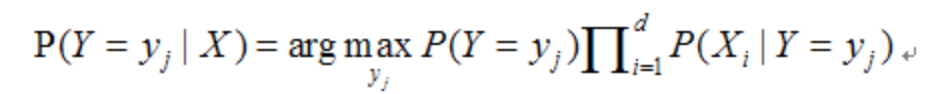
# Because all the Y and P(X) are the same, so we can equate the model to such model:
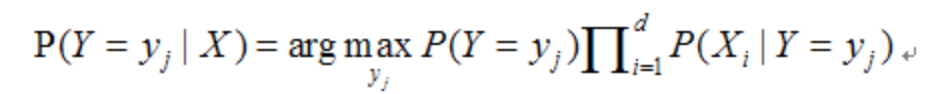
# So we need to calculate the probability and conditional probability of our data.

# a. Divide the dataset as train data for 70% and test data for 30%.  
### This review file has 2 columns, comment and rating. 
### comment is the review text we should 
### rating is the score of the reviews.
## Our goal is predicting the rating according to the comment text.

#### For this data, there are many continuous data. So I make them discreet as such rules:
#### First, I rounded them to integer number. Then, 
#### rate as 1 for numbers from 0 to 2;
#### rate as 2 for numbers from 3 to 4;
#### rate as 3 for numbers from 5 to 6;
#### rate as 4 for numbers from 7 to 8;
#### rate as 5 for numbers from 9 to 10;

#### After loading all the data to the jupyter, I did some pre-processing including text cleaning, tokenization and remove stopwords.

In [7]:
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import numpy as np


original_data = pd.read_csv('reviews.csv')
all_data = pd.DataFrame(original_data, columns=['comment', 'rating']).dropna()
all_data = shuffle(all_data)
all_data = pd.DataFrame(all_data).reset_index(drop=True)

def round_amount(a):
    res = int(float(a))
    if res == 0 or res == 1 or res == 2:
        label = 0
    if res == 3 or res == 4:
        label = 1
    if res == 5 or res == 6:
        label = 2
    if res == 7 or res == 8:
        label = 3
    if res == 9 or res == 10:
        label = 4
    return label


all_data['rating'] = all_data['rating'].apply(round_amount)
    

import re
import string

def clean_text(text):
    # Make text lowercase, remove text in square brackets,remove links,remove punctuation
    # remove words containing numbers.'''
    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text


# Applying the cleaning function to both test and training datasets
all_data['comment'] = all_data['comment'].apply(lambda x: clean_text(x))

import nltk
from nltk.corpus import stopwords

def remove_stopwords(text):
    words = [w for w in text if w not in stopwords.words('english')]
    return words

train = all_data[:int(0.7*len(all_data))]
train = pd.DataFrame(train)
test = all_data[int(0.7*len(all_data)):]
test = pd.DataFrame(test)
print("length of train data: ", len(train))
print("length of test data: ", len(test))
# tokenization
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
train['comment'] = train['comment'].apply(lambda x: tokenizer.tokenize(x))
test['comment'] = test['comment'].apply(lambda x: tokenizer.tokenize(x))
train['comment'] = train['comment'].apply(lambda x: remove_stopwords(x))
test['comment'] = test['comment'].apply(lambda x: remove_stopwords(x))

length of train data:  1846429
length of test data:  791327


In [8]:
print("train data:")
print(train.head())
print("\n")
print("test data:")
print(test.head())

train data:
                                             comment  rating
0              [game, didnt, suck, didnt, find, fun]       2
1  [initial, rating, got, lower, due, long, play,...       3
2  [cool, learn, study, games, like, become, cumb...       2
3  [probably, oldest, gamers, game, one, showing,...       2
4                                  [gets, old, fast]       2


test data:
                                                   comment  rating
1846429  [original, game, gazillon, expansions, game, t...       2
1846430  [favourite, version, rummy, theme, works, well...       3
1846431  [great, introduction, campaigns, napoleon, sys...       3
1846432  [high, trade, value, cards, sleeved, played, l...       3
1846433  [hexes, little, restrictive, aside, probably, ...       3


# b. Build a vocabulary as list. 
#### Building a vocabulary means build a dictionary for all the words with their occurrence under every label like this: {'happy': [10, 20, 30, 40, 50], ...}. This example means the word happy occurs 10 times under label 1, 20 times under label 2, 30 times under label 3 and so on.
#### To be more reasonable, I removed words whose occurrence are less than 10.

In [9]:
all_words = {}
all_s = ""
for index, row in train.iterrows():
    s = " ".join(row['comment'])
    all_s = all_s + s
all_words = all_s.lower().split(' ')

def count_words(data):
    vocabulary_list = {} # {'word':[]}
    for index, row in data.iterrows():
        for word in row['comment']:
            if word not in vocabulary_list:
                vocabulary_list[word] = [0, 0, 0, 0, 0]
            else:
                if row['rating'] == 0:
                    vocabulary_list[word][0] += 1
                if row['rating'] == 1:
                    vocabulary_list[word][1] += 1
                if row['rating'] == 2:
                    vocabulary_list[word][2] += 1
                if row['rating'] == 3:
                    vocabulary_list[word][3] += 1
                if row['rating'] == 4:
                    vocabulary_list[word][4] += 1
    for word in list(vocabulary_list.keys()):
        if vocabulary_list[word][0]+vocabulary_list[word][1]+vocabulary_list[word][2]+vocabulary_list[word][3]+vocabulary_list[word][4] < 10:
            del vocabulary_list[word]
    return vocabulary_list

vocabulary_list = count_words(train)
print('examples of the vocabulary list:')
print(list(vocabulary_list.items())[:20])

examples of the vocabulary list:
[('game', [43811, 139985, 489289, 808936, 295393]), ('didnt', [1825, 7954, 18987, 14128, 3488]), ('suck', [150, 340, 931, 1118, 293]), ('find', [1175, 4740, 15339, 20548, 7255]), ('fun', [4852, 20851, 103091, 187856, 46340]), ('initial', [207, 1261, 4930, 6804, 1572]), ('rating', [1774, 6197, 23511, 34048, 9241]), ('got', [1498, 4861, 15306, 23082, 7991]), ('lower', [172, 602, 2055, 2843, 659]), ('due', [473, 1849, 6296, 10206, 3242]), ('long', [2694, 10295, 29908, 35439, 11131]), ('play', [11282, 42663, 153352, 232802, 80007]), ('time', [4502, 15269, 50888, 82513, 34209]), ('cool', [586, 2585, 9401, 15694, 3736]), ('learn', [325, 1319, 7205, 20326, 9067]), ('study', [30, 116, 365, 572, 321]), ('games', [7166, 24060, 74610, 116441, 51530]), ('like', [8041, 33504, 111632, 166360, 44658]), ('become', [220, 883, 3694, 6876, 3117]), ('cumbersome', [42, 170, 510, 498, 122])]


#### write the vocabulary to a txt file.

In [10]:
f = open('data.txt','w')
f.write(str(vocabulary_list))
f.close()

# c. Calculate the probability and conditional probability for all the words.

#### calculate the total number of every label.

In [11]:
total_length = len(train)
    
def cal_label_count():
    result = []
    for i in range(5):
        count = 0
        for index, row in train.iterrows():
            if row['rating'] == i:
                count += 1
        result.append(count)
    return result

label_count = cal_label_count()
print(label_count)

[42940, 146435, 535168, 857125, 264761]


##### Probability of the occurrence: P[word] = num of documents containing this word / num of all documents
##### Conditional probability based on the sentiment: P[word | Positive]  = number of positive documents containing this word / num of all positive review documents

#### There are 5 labels totally. So I build a probability list and a conditional probability list to save different 5 labels.
#### To make our model more reasonable, I used Laplace smoothing to solve the problem of zero probability.

In [18]:
def cal_prob(i):
    count = 0
    for index, row in train.iterrows():
        if row['rating'] == i:
            count += 1
    return (count+1)/(len(train)+5)

# prior probability
prior_list = []
for i in range(5):
    prior_list.append(cal_prob(i))
print("prior probability: ", prior_list)  

def conditional_prob(word, i):
    all_count = label_count[i]
    if word in vocabulary_list:
        return (vocabulary_list[word][i]+1)/(all_count+5)
    if word not in vocabulary_list:
        return 1/(all_count+5)

print("\nOcurrence of going word under label 1: ", conditional_prob('going', 1))

prior probability:  [0.023256179208138498, 0.07930746509217226, 0.28983922523090455, 0.4642061400515805, 0.14339099041720418]

Ocurrence of going word under label 1:  0.030893198579623055


# d. predict test data
#### I classified all the test data accroding to our model and print the accuracy.

In [19]:
def classify(s):
    pred_list = []
    for i in range(5):
        pred = prior_list[i]
        for word in s:
            newpred = conditional_prob(word, i)
            pred *= newpred
        pred_list.append(pred)
    max_prob = max(pred_list)
    return pred_list.index(max_prob)

pred_right = 0
for index, row in test.iterrows():
    if row['rating'] == classify(row['comment']):
        pred_right += 1

accuracy = pred_right/len(test)
print("*********predict accuracy*********")
print(accuracy)

*********predict accuracy*********
0.4036574007963838
